# Suppressing instability on a Vlasov-Poisson system with an external electric field
## Example: Bump on tail distribution

$$f_{\text{eq}}(v) = \frac{9}{10\sqrt{2\pi}} \exp\left(-\frac{(v - \bar{v}_1)^2}{2}\right)
        + \frac{\sqrt{2}}{10\sqrt{\pi}} \exp\left(-2(v - \bar{v}_2)^2\right).$$

$$f(0, x, v) = \frac{\sqrt{2}\,\varepsilon}{10\sqrt{\pi}} \exp\left(-2(v - \bar{v}_2)^2\right)\cos(\beta x) + f_{\text{eq}}(v).$$

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp

import optax

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver
from VP_solver.auxiliary_functions import external_electric_field
from VP_solver.auxiliary_functions import make_cost_function_kl, make_cost_function_ee, make_cost_function_eet
from Utils.utils import plot_inital_solve, plot_results_BoT

jax.config.update("jax_enable_x64", True)

### Problem setup and forward solver setup

We aim to suppress instabilities in our plasma system at a time $T$. For this we solve the following PDE-constrained optimization problem:



$$\begin{align}
\min_{H} & \quad \mathcal{J}(f[H]) \\
\text{s.t.} & \quad  \left\{\begin{array}{l}
   \partial_{t}f(t,x,v) + v\partial_{x}f(t,x,v) - (E_{f}(t,x)+H(x)) \partial_{v}f(t,x,v) = 0 \,,\\
   E_{f}(t,x) = \partial_{x}V_{f}(t,x) \,, \\
   \partial_{xx} V_{f}(t,x) = 1 - \rho_{f}(t,x) =1 - \int  f(t,x,v) \,\mathrm{d}v\,.
\end{array}\right.
\end{align}$$


Here, the constraint is the Vlasov-Poisson (VP) system, a fundamental kinetic model for collisionless plasma. The function $f: (t, x, v) \in  [0,T] \times [0,L_{x}] \times [-L_{v},L_{v}] \rightarrow \mathbb{R}_{+}$ is the time-dependent particle distribution in phase space. The system's evolution is driven by the total electric field, which is a sum of the externally applied control field $H(x)$ and the self-generated electric field $E_{f}(t,x)$. This self-generated field is determined self-consistently: the charge density $\rho_{f}(t,x) = \int f(t,x,v)\,\mathrm{d}v$ determines the electric potential $V_f(t,x)$ via the Poisson equation, and $E_f$ is its gradient. We assume that we have periodic boundary conditions in the phase-space.

The objective function $\mathcal{J}$ is a functional designed to quantify the degree of instability in the plasma distribution $f$ and its variable is the external electric field $H$, which in turn is defined as

$$H(x;\boldsymbol{a},\boldsymbol{b}) = \sum_{k=1}^{N} a_{k}\cos\left(\frac{2\pi kx}{L_{x}}\right) + b_{k}\sin\left(\frac{2\pi kx}{L_{x}}\right)$$

where $\boldsymbol{a} = [a_{1},a_{2},...,a_{N}]^{\top}$ and $\boldsymbol{b} = [b_{1},b_{2},...,b_{N}]^{\top}$ are the coefficients we want to determine.

We solve our PDE using a semi-Lagrangian scheme.

In [2]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final_ = 40 # Adjusted for demonstration purposes
t_final = 40  
t_values_ = jnp.linspace(0, t_final_, int(t_final_ / dt))
t_values = jnp.linspace(0, t_final, int(t_final_ / dt))
L = 20 * jnp.pi
LV = 9.0

In [3]:
mesh = make_mesh(L, LV, nx, nv)

mu1 = -3
mu2 = 4.5
f_eq = (9 * jnp.exp(-0.5 * (mesh.V - mu1)**2))/(10*jnp.sqrt(2*jnp.pi))\
        + (jnp.sqrt(2) * jnp.exp(-2 * (mesh.V - mu2)**2))/(10*jnp.sqrt(jnp.pi))
epsilon1 = 0.001
epsilon2 = 0.0
k_0 = 0.1
f_iv = (epsilon1 * jnp.cos(k_0 * mesh.X) + epsilon2 * jnp.sin(k_0 * mesh.X)) \
        * (jnp.sqrt(2) * jnp.exp(-2 * (mesh.V - mu2)**2)) / (10*jnp.sqrt(jnp.pi)) + f_eq

In [4]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [5]:
# External field parameters
ak1 = jnp.array([[0.00141014], [-0.000320268]])  ## Good initial guess (ensure always shape (2,N)

# Compute the external field
H1 = external_electric_field(ak1, mesh, k_0)

In [6]:
f_array_1, E_array_1, ee_array_1 = solver_jit(f_iv, 0.0*H1, t_final=t_final) ## No H
f_array_2, E_array_2, ee_array_2 = solver_jit(f_iv, H1, t_final=t_final) ## Using good initial guess for H

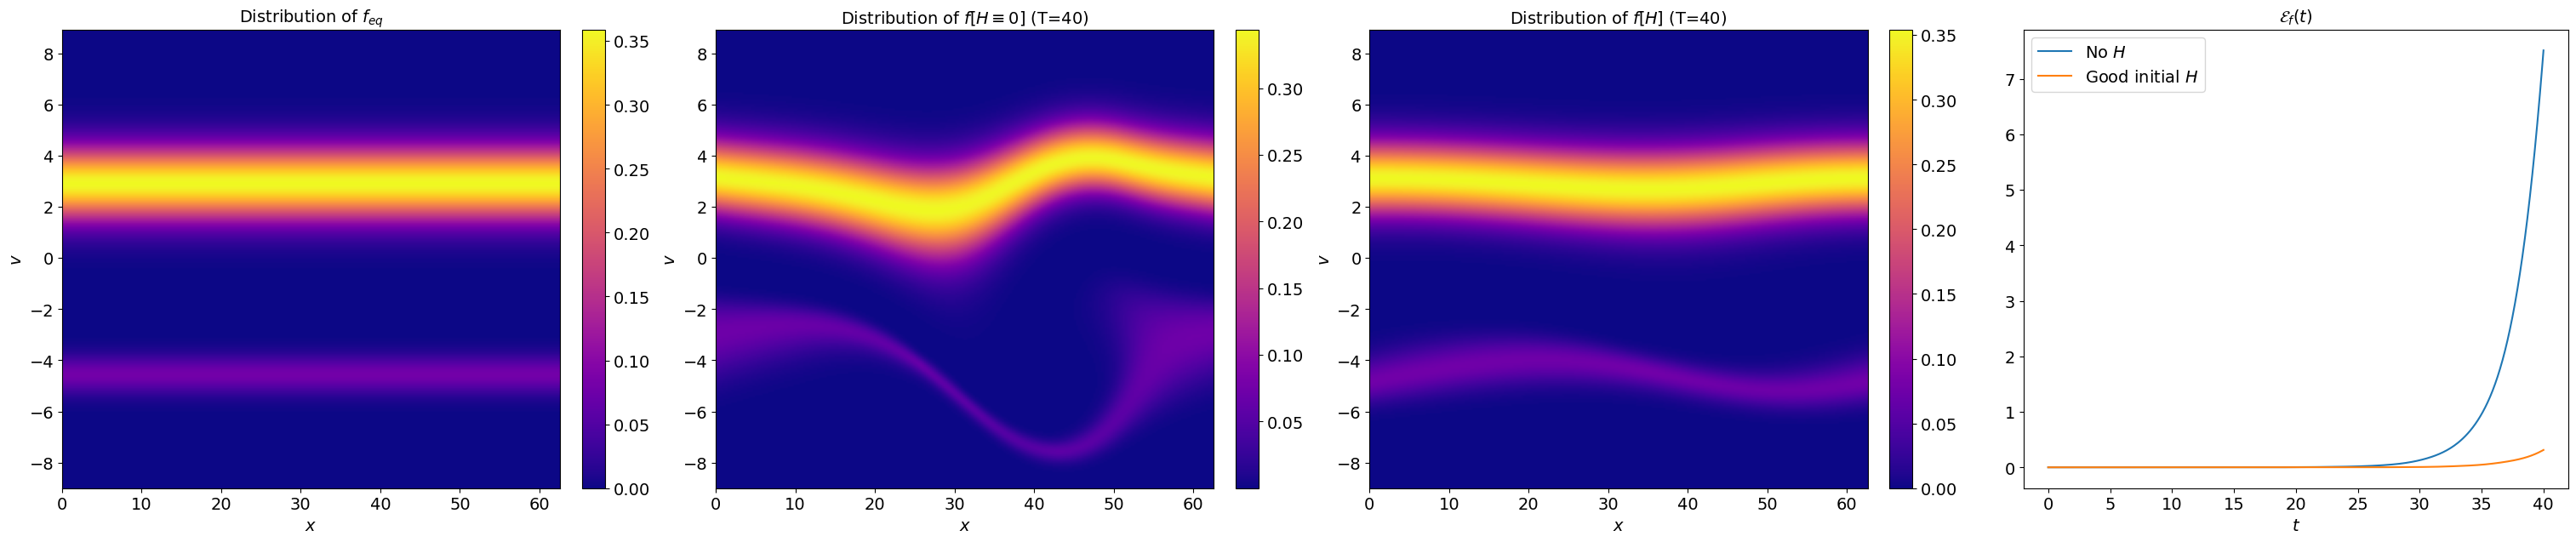

In [7]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_inital_solve(fig, axs, f_eq, f_array_1, ee_array_1, f_array_2, ee_array_2, mesh, t_values_, sci=False)

plt.show()

### Optimization: finding the coefficients of the external electric field to suppress instability

#### $KL$ objective function

Here we define our objective function as

$$\mathcal{J}(f[H]) = \text{KL}(f_{T}[H]||f_{\text{eq}}) = \int_{-L_{v}}^{L_{v}}\int_{0}^{L_{x}} f[H](T,x,v)\log\left(\frac{f[H](T,x,v)}{f_{\text{eq}}(v)}\right)\,\mathrm{d}x\,\mathrm{d}v\,.$$

In [8]:
cost_fn_kl = make_cost_function_kl(solver, solver_jit, f_iv, k_0, t_final)

##### Gradient Descent w/ line-search

In [9]:
maxiter = 100

solver_opt = optax.chain(
   optax.sgd(learning_rate=1.),
    optax.scale_by_zoom_linesearch(max_linesearch_steps=15)
)

def scan_fn_gdl(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_fn_kl)
    params = optax.apply_updates(params, updates)
    obj_value = cost_fn_kl(params)
    return (params, opt_state), obj_value

In [10]:
# Initial guess for the coefficients
k_total = 1
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.001, maxval=0.003)
opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_fn_kl))

# Run the optimization and collect objective values using `scan`
res_opt_kl_1, objective_values_kl_1 = jax.lax.scan(scan_fn_gdl, (ak_init_1, opt_state), None, length=maxiter)

ak_opt_kl_1, state = res_opt_kl_1

In [11]:
H_kl_1 = external_electric_field(ak_opt_kl_1, mesh, k_0)
ff_array_kl_1, E_array_kl_1, ee_array_kl_1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)

f_final_kl_1 = ff_array_kl_1

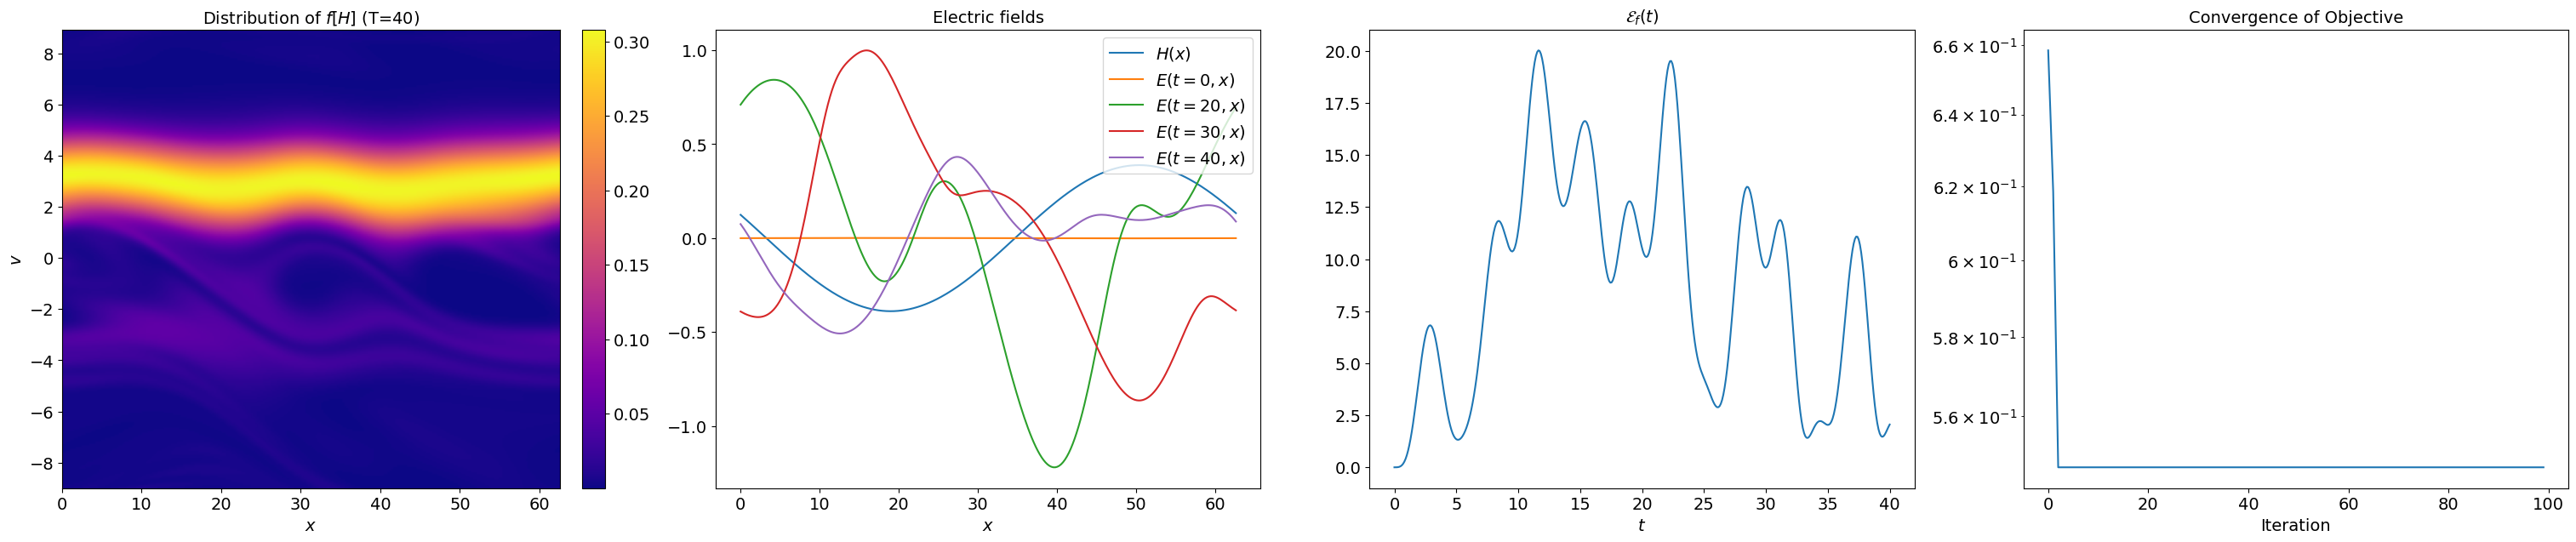

In [12]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_results_BoT(fig, axs, f_final_kl_1, E_array_kl_1, H_kl_1, ee_array_kl_1, objective_values_kl_1, t_values, mesh)

plt.show()

##### Gradient Descent

In [13]:
maxiter = 20000
learning_rate = 1e-9
solver_opt = optax.sgd(learning_rate=learning_rate)

def scan_fn_gd(carry, _):
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
    obj_value = cost_fn_kl(params)
    return (params, opt_state), obj_value

In [14]:
# Initial guess for the coefficients
k_total = 1
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.001, maxval=0.003)

opt_state = solver_opt.init(ak_init_2)
grad = jax.jit(jax.grad(cost_fn_kl))

# Run the optimization and collect objective values using `scan`
res_opt_kl_2, objective_values_kl_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)

ak_opt_kl_2, state = res_opt_kl_2

In [15]:
H_kl_2 = external_electric_field(ak_opt_kl_2, mesh, k_0)
ff_array_kl_2, E_array_kl_2, ee_array_kl_2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final_kl_2 = ff_array_kl_2

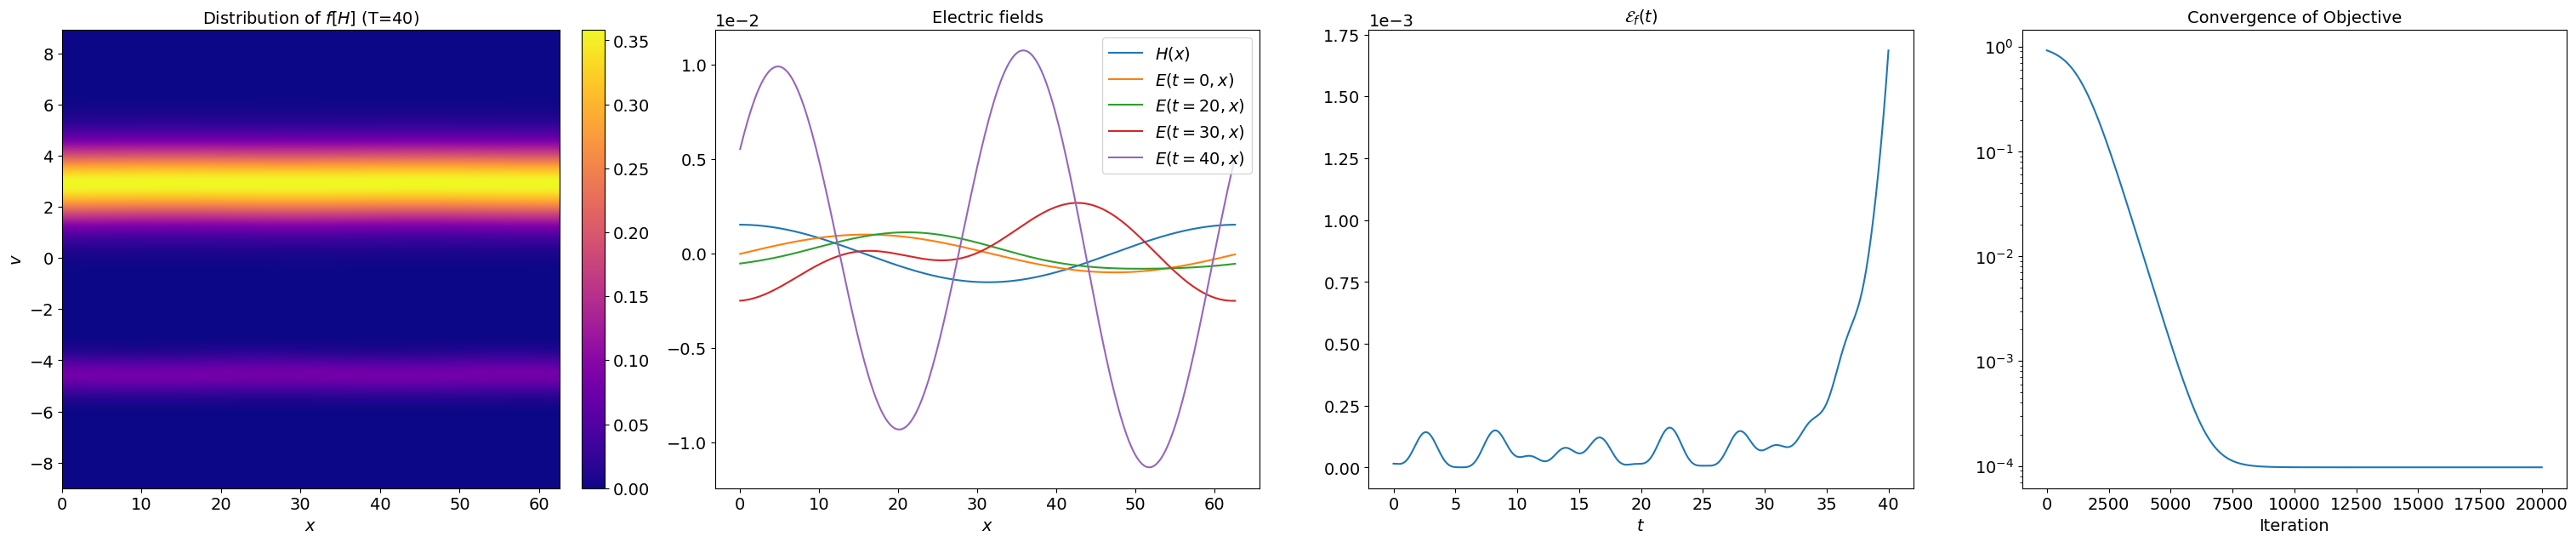

In [16]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_results_BoT(fig, axs, f_final_kl_2, E_array_kl_2, H_kl_2, ee_array_kl_2, objective_values_kl_2, t_values, mesh)

plt.show()

#### Electric energy objective function

Here we define our objective function as

$$\mathcal{J}(f[H]) = \mathcal{E}_{f[H]}(T) = \int_{0}^{L_{x}} [E_{f[H]}(T,x)]^{2}\,\mathrm{d}x\,.$$

In [17]:
cost_fn_ee = make_cost_function_ee(solver, solver_jit, f_iv, k_0, t_final)

##### Gradient Descent w/ line-search

In [18]:
maxiter = 100

solver_opt = optax.chain(
   optax.sgd(learning_rate=1.),
    optax.scale_by_zoom_linesearch(max_linesearch_steps=15)
)

def scan_fn_gdl(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_fn_ee)
    params = optax.apply_updates(params, updates)
    obj_value = cost_fn_ee(params)
    return (params, opt_state), obj_value

In [19]:
# Initial guess for the coefficients
k_total = 1
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.001, maxval=0.003)

opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_fn_ee))

# Run the optimization and collect objective values using `scan`
res_opt_ee_1, objective_values_ee_1 = jax.lax.scan(scan_fn_gdl, (ak_init_1, opt_state), None, length=maxiter)

ak_opt_ee_1, state = res_opt_ee_1

In [20]:
H_ee_1 = external_electric_field(ak_opt_ee_1, mesh, k_0)
ff_array_ee_1, E_array_ee_1, ee_array_ee_1 = solver.run_forward_jax_scan(f_iv, H_ee_1, t_final)

f_final_ee_1 = ff_array_ee_1

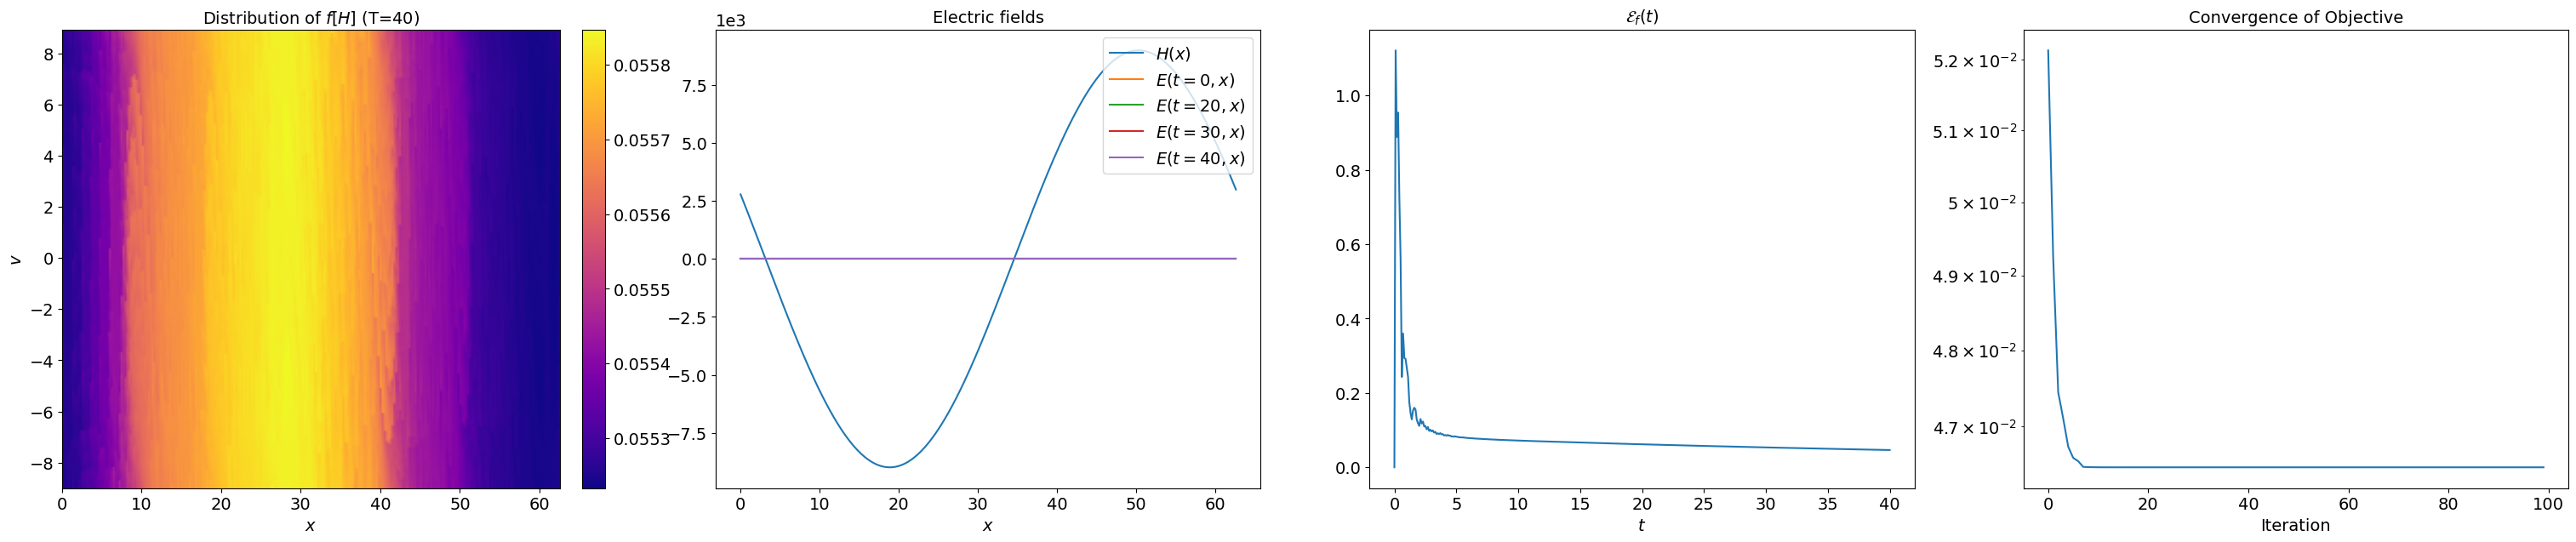

In [21]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_results_BoT(fig, axs, f_final_ee_1, E_array_ee_1, H_ee_1, ee_array_ee_1, objective_values_ee_1, t_values, mesh)

plt.show()

##### Gradient Descent

In [22]:
maxiter = 3000
learning_rate = 1e-9
solver_opt = optax.sgd(learning_rate=learning_rate)

def scan_fn_gd(carry, _):
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
    obj_value = cost_fn_ee(params)
    return (params, opt_state), obj_value

In [23]:
# Initial guess for the coefficients
k_total = 1
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.001, maxval=0.003)

opt_state = solver_opt.init(ak_init_2)
grad = jax.jit(jax.grad(cost_fn_ee))

# Run the optimization and collect objective values using `scan`
res_opt_ee_2, objective_values_ee_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)

ak_opt_ee_2, state = res_opt_ee_2

In [24]:
H_ee_2 = external_electric_field(ak_opt_ee_2, mesh, k_0)
ff_array_ee_2, E_array_ee_2, ee_array_ee_2 = solver.run_forward_jax_scan(f_iv, H_ee_2, t_final)

f_final_ee_2 = ff_array_ee_2

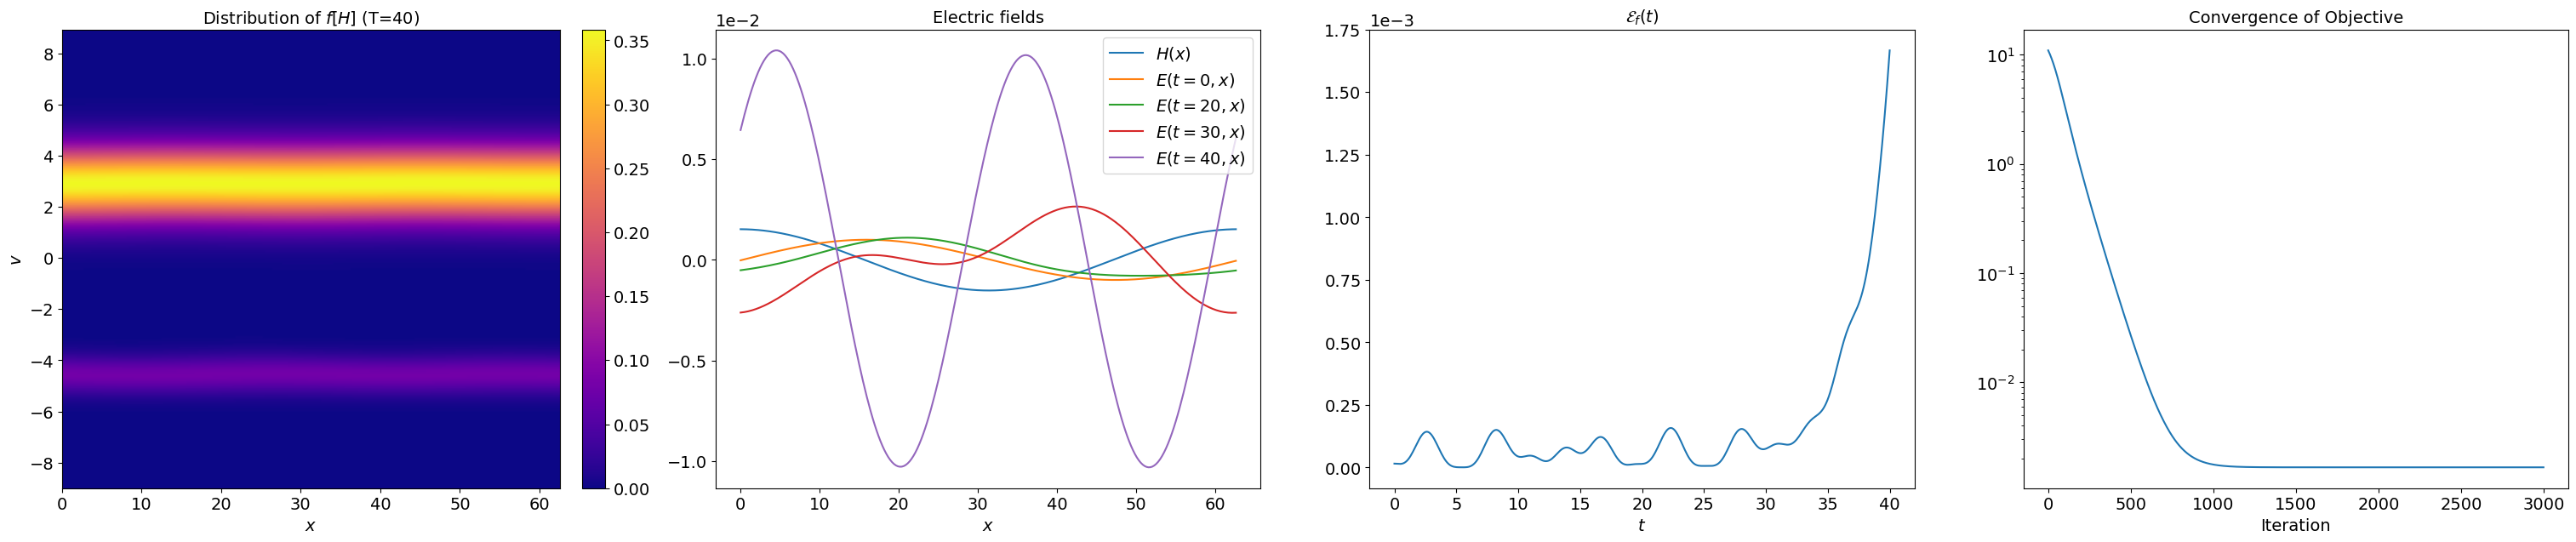

In [25]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_results_BoT(fig, axs, f_final_ee_2, E_array_ee_2, H_ee_2, ee_array_ee_2, objective_values_ee_2, t_values, mesh)

plt.show()

#### Electric energy in time objective function

Here we define our objective function as

$$\mathcal{J}(f[H]) = \int_{0}^{T}\mathcal{E}_{f[H]}(t)\,\mathrm{d}t = \int_{0}^{T}\int_{0}^{L_{x}} [E_{f[H]}(T,x)]^{2}\,\mathrm{d}x\,\mathrm{d}t\,.$$

In [26]:
cost_fn_eet = make_cost_function_eet(solver, solver_jit, f_iv, k_0, t_final)

##### Gradient Descent w/ line-search

In [27]:
maxiter = 100

solver_opt = optax.chain(
   optax.sgd(learning_rate=1.),
    optax.scale_by_zoom_linesearch(max_linesearch_steps=15)
)

def scan_fn_gdl(carry, _):
    params, opt_state = carry
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver_opt.update(grad, opt_state, params,
                                           value=value, grad=grad, value_fn=cost_fn_eet)
    params = optax.apply_updates(params, updates)
    obj_value = cost_fn_eet(params)
    return (params, opt_state), obj_value

In [28]:
# Initial guess for the coefficients
k_total = 1
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.001, maxval=0.003)

opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_fn_eet))

# Run the optimization and collect objective values using `scan`
res_opt_eet_1, objective_values_eet_1 = jax.lax.scan(scan_fn_gdl, (ak_init_1, opt_state), None, length=maxiter)

ak_opt_eet_1, state = res_opt_eet_1

In [29]:
H_eet_1 = external_electric_field(ak_opt_eet_1, mesh, k_0)
ff_array_eet_1, E_array_eet_1, ee_array_eet_1 = solver.run_forward_jax_scan(f_iv, H_eet_1, t_final)

f_final_eet_1 = ff_array_eet_1

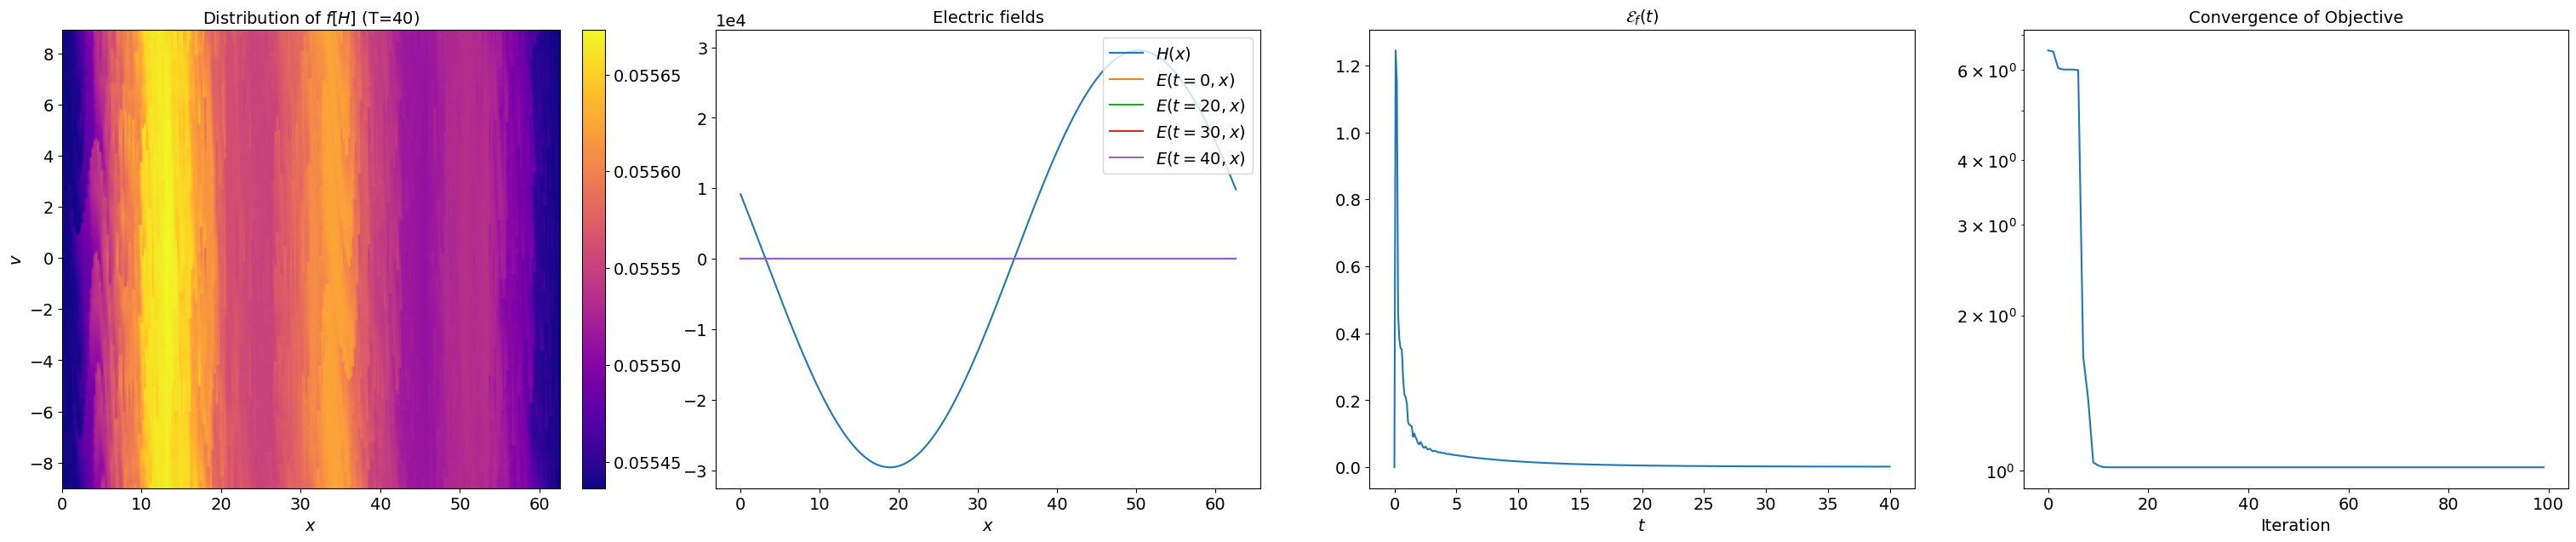

In [30]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_results_BoT(fig, axs, f_final_eet_1, E_array_eet_1, H_eet_1, ee_array_eet_1, objective_values_eet_1, t_values, mesh)

plt.show()

##### Gradient Descent

In [31]:
maxiter = 3000
learning_rate = 1e-9
solver_opt = optax.sgd(learning_rate=learning_rate)

def scan_fn_gd(carry, _):
    params, opt_state = carry
    grad_ = grad(params)
    updates, opt_state = solver_opt.update(grad_, opt_state, params)
    params = optax.apply_updates(params, updates)
    obj_value = cost_fn_eet(params)
    return (params, opt_state), obj_value

In [32]:
# Initial guess for the coefficients
k_total = 1
ak_init_2 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-0.001, maxval=0.003)

opt_state = solver_opt.init(ak_init_1)
value_and_grad = jax.jit(optax.value_and_grad_from_state(cost_fn_eet))

# Run the optimization and collect objective values using `scan`
res_opt_eet_2, objective_values_eet_2 = jax.lax.scan(scan_fn_gd, (ak_init_2, opt_state), None, length=maxiter)

ak_opt_eet_2, state = res_opt_eet_2

In [33]:
H_eet_2 = external_electric_field(ak_opt_eet_2, mesh, k_0)
ff_array_eet_2, E_array_eet_2, ee_array_eet_2 = solver.run_forward_jax_scan(f_iv, H_eet_2, t_final)

f_final_eet_2 = ff_array_eet_2

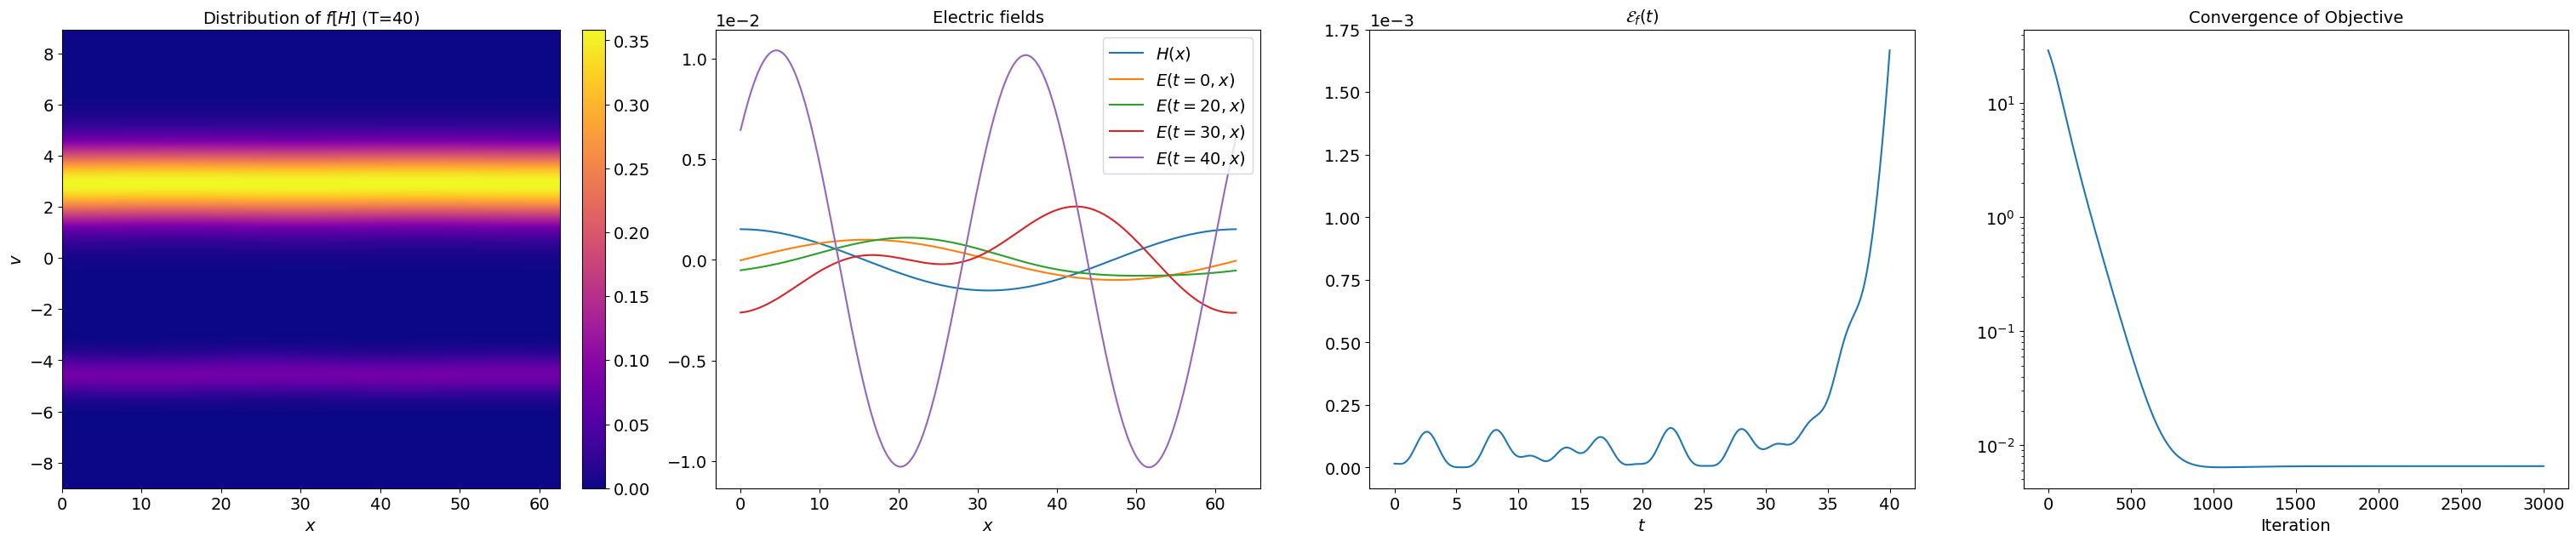

In [34]:
fig, axs = plt.subplots(1,4 ,figsize=(38, 7))

plot_results_BoT(fig, axs, f_final_eet_2, E_array_eet_2, H_eet_2, ee_array_eet_2, objective_values_eet_2, t_values, mesh)

plt.show()